# Import Libraries and Models

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import joblib
from albumentations import Compose, Resize, HorizontalFlip, RandomBrightnessContrast, GaussNoise, CLAHE, HueSaturationValue


from skimage.feature import local_binary_pattern
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

: 

# Image Augmentation Pipeline Definition

In [ ]:
augmentation_pipeline = Compose([
    Resize(224, 224),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    CLAHE(p=0.3),
    GaussNoise(p=0.2),
    HueSaturationValue(p=0.3)
])

# Image Loading and Augmentation 

In [ ]:
def load_images_with_labels(base_path):
    fire_dir = os.path.join(base_path, 'Train', 'Fire')  # Train/Fire directory
    neutral_dir = os.path.join(base_path, 'Train', 'Neutral')  # Train/Neutral directory

    data = []
    labels = []

    for label, folder in enumerate([neutral_dir, fire_dir]):  # 0: neutral, 1: fire
        for filename in tqdm(os.listdir(folder), desc=f"Loading {folder}"):
            file_path = os.path.join(folder, filename)
            img = cv2.imread(file_path)
            if img is not None:
                augmented = augmentation_pipeline(image=img)
                img_aug = augmented['image']
                data.append(img_aug)
                labels.append(label)

    return np.array(data), np.array(labels)

# Load and augment the data
base_dataset_path = r"D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionFinal\FireDatasetPCD"
X_images, y_labels = load_images_with_labels(base_dataset_path)

Loading D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionFinal\FireDatasetPCD\Train\Neutral: 100%|██████████| 1333/1333 [00:09<00:00, 138.85it/s]
Loading D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionFinal\FireDatasetPCD\Train\Fire: 100%|██████████| 987/987 [00:03<00:00, 271.94it/s]


# Visualize Sample Augmented Images 

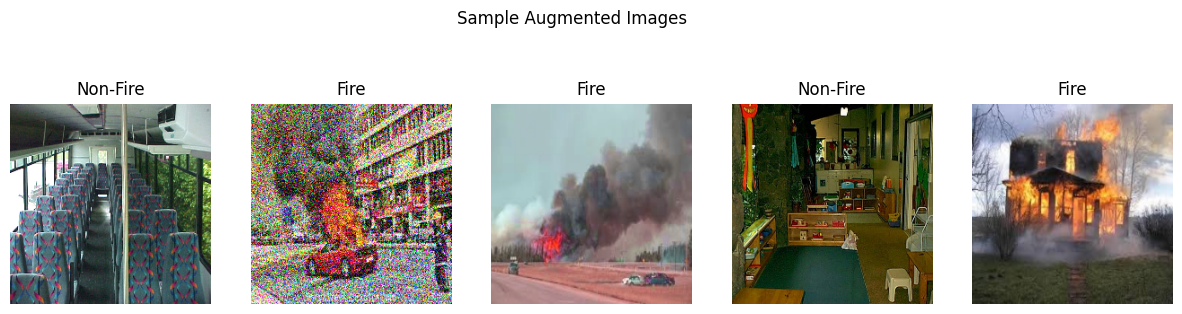

In [ ]:
def visualize_sample_images(images, labels, class_names=["Non-Fire", "Fire"], samples=5):
    plt.figure(figsize=(15, 4))
    for i in range(samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        label = labels[idx]
        plt.subplot(1, samples, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.title(class_names[label])
        plt.axis("off")
    plt.suptitle("Sample Augmented Images")
    plt.show()

# Visualize sample images
visualize_sample_images(X_images, y_labels)

# Feature Extraction using HSV, LBP, and CNN (VGG16)


In [ ]:
# Load pre-trained VGG16 model (excluding top layers)
cnn_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_hsv_histogram(image):
    """Extracts HSV histogram features from an image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_lbp_texture(image):
    """Extracts LBP (Local Binary Pattern) texture features from an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)
    return lbp_hist

def extract_cnn_features(image):
    """Extracts CNN features from an image using the VGG16 model."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array = img_to_array(image_rgb)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = cnn_model.predict(img_array, verbose=0)
    return features.flatten()

def extract_all_features_batch(images):
    """Extracts all features (color, texture, CNN) for a batch of images."""
    all_features = []
    for img in tqdm(images, desc="Extracting features"):
        color_feat = extract_hsv_histogram(img)
        texture_feat = extract_lbp_texture(img)
        cnn_feat = extract_cnn_features(img)
        combined = np.concatenate([color_feat, texture_feat, cnn_feat])
        all_features.append(combined)
    return np.array(all_features)

# Extract features from the dataset
X_features = extract_all_features_batch(X_images)


Extracting features: 100%|██████████| 2319/2319 [03:14<00:00, 11.92it/s]


# Visualizing Extracted Feature Vectors Distribution


Feature shape per image: (2319, 25609)


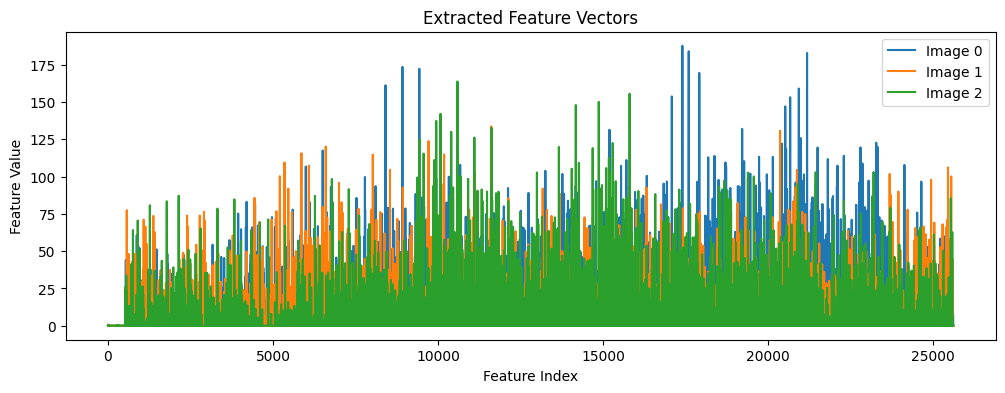

In [ ]:
# Feature shape inspection
print("Feature shape per image:", X_features.shape)

# Visualize feature vector distribution for a few samples
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(X_features[i], label=f"Image {i}")
plt.title("Extracted Feature Vectors")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# Feature Selection Using SelectKBest or RFE & Saving the Selector


In [ ]:
# Directory to save feature selector
output_dir = r"D:\OneDrive - American International University-Bangladesh\SemesterVIII\Final VIII\Machine Learning\FireDetectionFinal"
selector_save_path = os.path.join(output_dir, "feature_selector.pkl")

def select_features_filter(X, y, k=300):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    print(f"[SelectKBest] Selected {X_selected.shape[1]} features.")
    return X_selected, selector

def select_features_rfe(X, y, k=300):
    estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    selector = RFE(estimator, n_features_to_select=k, step=50, verbose=1)
    X_selected = selector.fit_transform(X, y)
    print(f"[RFE] Selected {X_selected.shape[1]} features.")
    return X_selected, selector

# Toggle method here
use_rfe = True

if use_rfe:
    X_selected, feature_selector = select_features_rfe(X_features, y_labels, k=300)
else:
    X_selected, feature_selector = select_features_filter(X_features, y_labels, k=300)

# Save the selector for reuse
joblib.dump(feature_selector, selector_save_path)
print(f"Feature selector saved at: {selector_save_path}")

Fitting estimator with 25609 features.
Fitting estimator with 25559 features.
Fitting estimator with 25509 features.
Fitting estimator with 25459 features.
Fitting estimator with 25409 features.
Fitting estimator with 25359 features.
Fitting estimator with 25309 features.
Fitting estimator with 25259 features.
Fitting estimator with 25209 features.
Fitting estimator with 25159 features.
Fitting estimator with 25109 features.
Fitting estimator with 25059 features.
Fitting estimator with 25009 features.
Fitting estimator with 24959 features.
Fitting estimator with 24909 features.
Fitting estimator with 24859 features.
Fitting estimator with 24809 features.
Fitting estimator with 24759 features.
Fitting estimator with 24709 features.
Fitting estimator with 24659 features.
Fitting estimator with 24609 features.
Fitting estimator with 24559 features.
Fitting estimator with 24509 features.
Fitting estimator with 24459 features.
Fitting estimator with 24409 features.
Fitting estimator with 24

# Visualizing Top 30 Feature Importances Using RFE with RandomForestClassifier


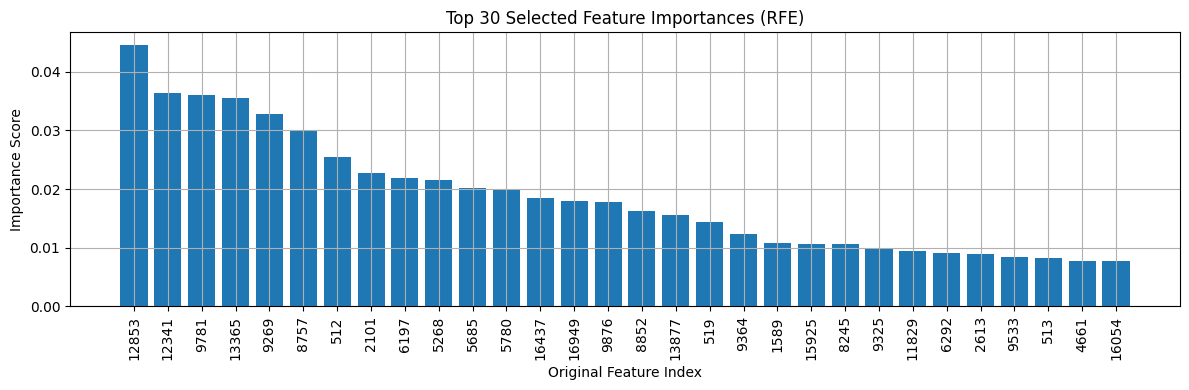

In [ ]:
# Only valid if using RFE with RandomForestClassifier
if hasattr(feature_selector, "estimator_") and hasattr(feature_selector.estimator_, "feature_importances_"):
    selected_indices = feature_selector.get_support(indices=True)
    selected_importances = feature_selector.estimator_.feature_importances_

    # Map original feature index to importance
    importance_dict = {idx: imp for idx, imp in zip(selected_indices, selected_importances)}
    sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    top_k = sorted_items[:30]  # Top 30 features

    # Data for plotting
    feature_ids = [idx for idx, _ in top_k]
    importances = [imp for _, imp in top_k]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(feature_ids)), importances, tick_label=feature_ids)
    plt.title("Top 30 Selected Feature Importances (RFE)")
    plt.xlabel("Original Feature Index")
    plt.ylabel("Importance Score")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available. Ensure you're using RFE with a RandomForestClassifier.")


# Model Training, Evaluation, and Confusion Matrix 


Accuracy: 94.40%

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.97      0.94      0.95       267
        Fire       0.92      0.95      0.94       197

    accuracy                           0.94       464
   macro avg       0.94      0.95      0.94       464
weighted avg       0.94      0.94      0.94       464



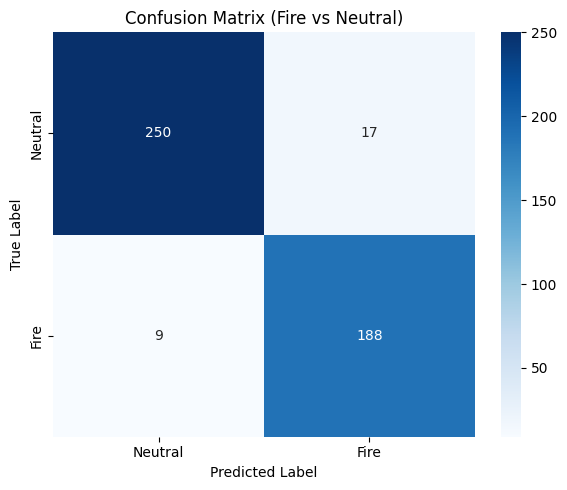

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {100*acc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Neutral", "Fire"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Neutral", "Fire"],
            yticklabels=["Neutral", "Fire"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fire vs Neutral)")
plt.tight_layout()
plt.show()

# Model Performance Visualization

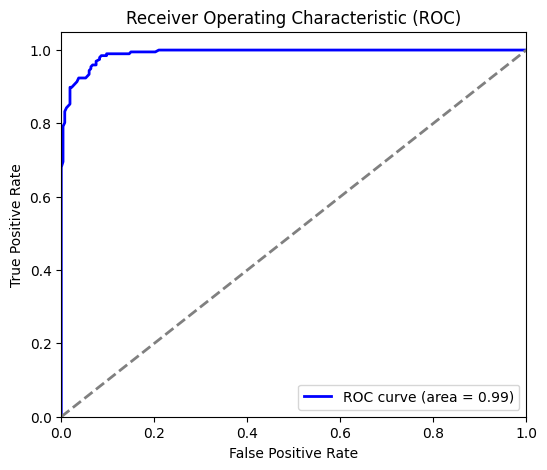

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Model Saving

In [ ]:
model_save_path = "random_forest_fire_detection_model.pkl"
joblib.dump(clf, model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to random_forest_fire_detection_model.pkl


# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X_selected, y_labels, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")


Cross-validation scores: [0.93534483 0.93965517 0.97413793 0.96336207 0.95680346]
Mean CV score: 0.9539
